---
# Tarea 1 Deep Learning
- Integrantes: Matias Aguilera, Jonas Oviedo y Natalia Romero
---

## Introducción
El presente trabajo tiene como objetivo la creación e implementación de una regresión logística. La creación fue hecha desde cero, sin el uso de librerías externas y se basa en el articulo de Medium "Logistic Regression From Scratch" [1]. Además, se exploraron distintas técnicas para su validaciónm, tales como PCA y K Fold Cross Validation. Su implementación se da en el uso de datos de "Spambase", la cual fue creada para la clasificación de correos electrónicos como spam o no spam. Contiene más de 4600 datos los cuales caracterizan a las siguientes columnas, las cuales serán escenciales para la eventual predicción:
- **word_freq_WORD:** Porcentaje de palabras en el correo electrónico que coinciden con "WORD".
- **char_freq_CHAR:** Porcentaje de caracteres en el correo electrónico que coinciden con "CHAR".
- **capital_run_length_average:** Promedio de la longitud de secuencias ininterrumpidas de mayúsculas.
- **capital_run_length_longest:** Longitud de la secuencia ininterrumpida más larga de mayúsculas.
- **capital_run_length_total:** Suma total de la longitud de secuencias ininterrumpidas de mayúsculas.
- **spam:** La variable objetivo, donde 1 indica que el correo electrónico es spam y 0 que no lo es.




1. Kushal, K. (2023). Logistic Regression from Scratch. Medium. https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226

## Importar librerías
En primer lugar, se importa la librería "Numpy" la cual nos ayudará a trabajar con los datos. Además, se importa la librería "Matplotlib" que será de ayuda para graficar los resultados obtenidos y generar analisis en base a su interpretación.

In [19]:
import numpy as np 
import matplotlib.pyplot as plt

## Función para calcular distribución de clases
Se crea esta función para calcular el porcentaje de distribución de las clases, la cual se utilizará eventualmente para medir como se distribuyen las clases en el dataset de entranamiento y en las predicciones finales.

In [20]:
def classes_distribution(arr):
    # conteo de las clases true (1) y false (0)
    count_true = np.count_nonzero(arr)
    count_false = arr.size - count_true

    # calcula el porcentaje por cada clase
    percent_true = (count_true / arr.size) * 100
    percent_false = (count_false / arr.size) * 100

    print(f"TRUE: {count_true} ({percent_true:.2f}%)")
    print(f"FALSE: {count_false} ({percent_false:.2f}%)")

## Implementación de Logistic Regression
Se crean distintas funciones para la clase "Logistic Regression", las cuales son detalladas a continuación:
### Párametros de la clase: 
- **lr:** Learning rate (tasa de aprendizaje), controla el tamaño del paso durante la optimización por descenso de gradiente. 
- **n_iters:** Número de iteraciones para que se ejecute el proceso de entrenamiento.
- **weights:** Coeficientes para las características de entrada, ajustados durante el entrenamiento para minimizar la pérdida.
- **bias:** Sesgo añadido a la función.
- **losses:** Lista para registrar el valor de la función de pérdida en cada iteración del entrenamiento.
### Funciones
- **sigmoid:** Esta función representa la base del modelo la cual está dada por la siguiente ecuación:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- **compute_loss:** Calcula la pérdida utilizando la entropía cruzada binaria, la cual se usa para medir el error entre las predicciones del modelo $y_{pred}$ y las etiquetas verdaderas $y_{true}$. La fórmula es:
$$
\text{BCE} = -\frac{1}{N} \sum_{i=0}^N \left( y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right)
$$
Donde: 

    - $ N $: Es el número total de los datos.
    - $ y_i $: Es la etiqueta verdadera del i-ésimo dato, que puede ser 0 o 1.
    - $ p_i $:  Es la etiqueta predicha de que el i-ésimo dato pertenezca a la clase 1.
- **feed_forward:** Calcula y devuelve las probabilidades predichas utilizando la función sigmoide de la suma ponderada de las entradas y los pesos del modelo. La ecuación es:
$$ A=\sigma(X⋅w+b)$$
 Donde:
 - $X$: Son las entradas.
 - $w$: Son los pesos.
 - $b$: Es el sesgo.
Además, para mitigar el overfitting, que se da especialmente en escenarios con muchas datos o caracteristicas, se añade un término de penalización L2 que depende del cuadrado de la magnitud de los coeficientes del modelo. Este término de regularización es proporcional al cuadrado de la norma de los pesos, ponderado por el parámetro de regularización $\lambda$.
$$ \text{L2 Regularization Penalty} = \frac{\lambda}{2} \sum \text{weights}^2 $$

- **fit:** Entrena el modelo utilizando descenso de gradiente. Inicializa los pesos y el sesgo a cero y los actualiza iterativamente basándose en el gradiente de la función de pérdida. La función también registra la pérdida en cada iteración para su evaluación posterior.
- **predict:** Realiza predicciones sobre un conjunto de datos $X$. Utiliza un umbral (threshold) de 0.5 para clasificar las predicciones como 0 o 1. Además, devuelve un array con los IDs y las clases predichas para poder generar un submission en kaggle.
- **plot_loss:** Permite visualizar la pérdida en función del número de iteraciones. Esta gráfica es útil para evaluar cómo el modelo aprende a lo largo del tiempo y si está convergiendo correctamente.

In [21]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000, reg_lambda=0.01):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.reg_lambda = reg_lambda 
        self.bias = None
        self.losses = []
         
    # función sigmoide
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # binary cross entropy con regularización L2
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        l2_penalty = 0.5 * self.reg_lambda * np.sum(self.weights ** 2)  # Término de penalización L2
        return -np.mean(y1 + y2) + l2_penalty
    
    # función que calcula y devuelve las probabilidades predichas utilizando la función sigmoide según las entradas y pesos.
    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A
    # función que permite entrenar el modelo basado en el descenso de gradiente
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            loss = self.compute_loss(y, A)  # Computar la perdida actual
            self.losses.append(loss)  # registrar perdida

            dz = A - y  # Derivada
            dw = (1 / n_samples) * np.dot(X.T, dz)
            db = (1 / n_samples) * np.sum(dz)

            # Actualizar parametros
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    # funcion para calcular las predicciones
    def predict(self, X):
        threshold = 0.5
        
        # hacer prediccion
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = np.array([1 if i > threshold else 0 for i in y_predicted])
        
        classes_distribution(y_predicted_cls)
        
        # generar array
        ids = np.arange(len(y_predicted_cls))
        arr = np.core.records.fromarrays([ids, y_predicted_cls], names='ID,Class')
        return arr
    #funcion para graficar la perdida vs iteraciones
    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Loss') # grafica la perdida del modelo actual
        plt.title('Loss vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

## Train Dataset
A continuación, se obtienen los datos del archivo ``train_data.csv``, donde están todos los datos que servirán para el entrenamiento del modelo. Esto se con ayuda de la librería Numpy. Además, se muestra como están distribuidas las clases.

In [22]:
train = np.genfromtxt('train_data.csv', delimiter=',', skip_header=1) 
X_train = train[:, :-1] 
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
y_train = train[:, -1] 
classes_distribution(y_train)

TRUE: 1450 (39.40%)
FALSE: 2230 (60.60%)


## Test Dataset
A continuación, se obtienen los datos del archivo ``test_data.csv``, donde están todos los datos que servirán para el testeo del modelo. Esto se con ayuda de la librería Numpy. 

In [23]:
test = np.genfromtxt('test_data.csv', delimiter=',', skip_header=1) 
X_test = test[:, :-1] 
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

## Entrenando el modelo
Luego, se procede a entrenar el modelo haciendo uso de la clase ``LogisticRegression``anteriormente creada, con un learning rate de 0.09 y 1500 iteraciones.

In [24]:
lr = LogisticRegression(learning_rate=0.09, n_iters=1500)
lr.fit(X_train, y_train)

Se generan las predicciones y se exportan a un archivo csv.

In [25]:
predictions = lr.predict(X_test)
np.savetxt("submission.csv", predictions, delimiter=",", fmt='%d', header="ID,Class", comments='')

TRUE: 339 (36.81%)
FALSE: 582 (63.19%)


Se muestra el grafico de perdidas vs iteraciones.

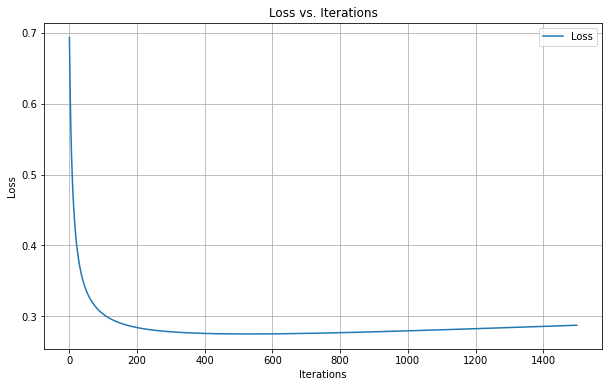

In [26]:
lr.plot_loss()

## PCA
Esta función realiza el Análisis de Componentes Principales (PCA), la cual es fundamental para la reducción de dimensiones, permitiendo una visualización simplificada y el análisis de datos de alta dimensionalidad. Esto se hace sobre el conjunto de datos `X` que son los de train, reduciendo su dimensionalidad a `n_components` componentes principales. A continuación, se detallan los pasos incluídos en el código:

1. **Normalización**: Los datos se estandarizan para tener media cero y varianza unitaria.
2. **Covarianza**: Se calcula la matriz de covarianza para capturar las relaciones lineales entre las variables.
3. **Autovalores y autovectores**: Se extraen para determinar la dirección de la mayor varianza en los datos.
4. **Selección de componentes**: Se seleccionan los componentes principales basándose en los autovalores más grandes.
5. **Transformación de datos**: Los datos originales se proyectan sobre los componentes principales seleccionados para obtener la versión transformada y reducida.


In [27]:
def pca(X, n_components):
    # normalización de datos
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # cálculo de la matriz de covarianza
    covariance_matrix = np.cov(X_normalized, rowvar=False)

    # cálculo de autovalores y autovectores
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # selección de componentes principales
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Orden descendente
    selected_indices = sorted_indices[:n_components]
    principal_components = eigenvectors[:, selected_indices]

    # transformación de datos
    X_transformed = np.dot(X_normalized, principal_components)

    return X_transformed

Aplicar PCA

In [28]:
n_components = 30  # define el número de componentes principales
X_train_pca = pca(X_train, n_components)
X_test_pca = pca(X_test, n_components)

Entrenar y probar el modelo de regresión logística con datos transformados

In [29]:
lr_pca = LogisticRegression(learning_rate=0.09, n_iters=1500)
lr_pca.fit(X_train_pca, y_train)

Se generan las predicciones y se exportan a un archivo csv.

In [30]:
predictions = lr_pca.predict(X_test_pca)
np.savetxt("submission_pca.csv", predictions, delimiter=",", fmt='%d', header="ID,Class", comments='')

TRUE: 441 (47.88%)
FALSE: 480 (52.12%)


Se muestra el grafico de perdidas vs iteraciones.

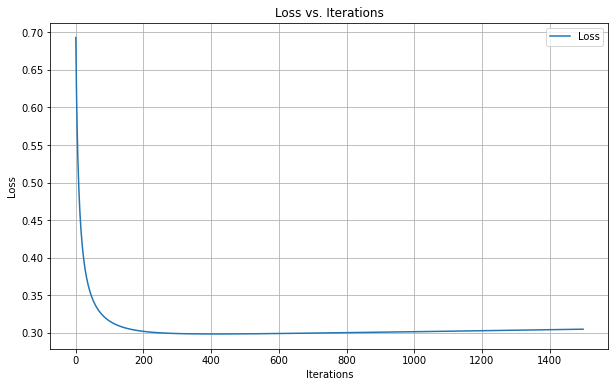

In [31]:
lr_pca.plot_loss()

## Cálculo de métricas

La función `calculate_metrics` calcula métricas claves de evaluación de modelos de clasificación: exactitud (accuracy), precisión (precision) y sensibilidad (recall). Estas métricas se basan en los valores de:

- **Verdaderos Positivos (TP)**: Predicciones correctas de la clase positiva.
- **Verdaderos Negativos (TN)**: Predicciones correctas de la clase negativa.
- **Falsos Positivos (FP)**: Predicciones incorrectas donde la clase negativa es etiquetada como positiva.
- **Falsos Negativos (FN)**: Predicciones incorrectas donde la clase positiva es etiquetada como negativa.

Métricas calculadas:
- **Exactitud (Accuracy)**: Proporción de predicciones correctas entre el total de casos.
- **Precisión (Precision)**: Proporción de predicciones positivas correctas respecto al total de predicciones positivas.
- **Sensibilidad (Recall)**: Proporción de predicciones positivas correctas respecto al total de casos positivos reales.

In [32]:
def calculate_metrics(y_true, y_pred):
    # true positives, false positives, true negatives, and false negatives
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    # metricas
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

## K-Fold Cross Validation

K-Fold Cross Validation es una técnica para evaluar la capacidad de generalización de un modelo estadístico. Consiste en dividir el conjunto de datos en `k` subconjuntos independientes, y luego iterativamente entrenar el modelo en `k-1` de estos subconjuntos mientras se utiliza el restante para validar el modelo. Es útil para reducir la variabilidad y obtener una estimación más fiable del rendimiento del modelo.

Esta función divide el conjunto de datos en `k` subconjuntos (o "folds") de manera aleatoria. Cada fold tiene aproximadamente el mismo tamaño. Esto se logra mediante el cálculo del tamaño de cada fold, ajustando los últimos para compensar cualquier diferencia debida al tamaño del conjunto de datos no divisible exactamente por `k`. El resultado es una lista de índices que representan cada fold.

In [33]:
def k_fold_split(X, y, k):
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(k, n_samples // k)
    fold_sizes[:n_samples % k] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append((indices[start:stop]))
        current = stop
    return folds

Se realiza la validación cruzada de K Folds en el dataset. Para cada fold, separa los datos en un conjunto de entrenamiento y un conjunto de prueba, entrena el modelo de regresión logística y evalúa su rendimiento usando métricas como precisión, exactitud y sensibilidad. Además, recopila las pérdidas de entrenamiento de cada fold para su posterior visualización.

In [34]:
def cross_validation(X, y, k=5, learning_rate=0.09, n_iters=1500):
    folds = k_fold_split(X, y, k)
    scores = []
    losses = []
    for i in range(k):
        train_i = np.hstack([folds[j] for j in range(k) if j != i])
        test_i = folds[i]
        X_train, y_train = X[train_i], y[train_i]
        X_test, y_test = X[test_i], y[test_i]
        lr = LogisticRegression(learning_rate, n_iters)
        lr.fit(X_train, y_train)
        losses.append(lr.losses)
        predictions = lr.predict(X_test)
        score = calculate_metrics(predictions['Class'],y_test)
        scores.append(score)
        print(f"Fold {i+1}, Score: {score}")
        lr.plot_loss()
        print("----------------")

    plot_all_k_folds_loss(losses)


Esta función grafica las curvas de pérdida de cada fold de la validación cruzada en una sola figura. Permite visualizar cómo cada fold contribuyó al aprendizaje del modelo, mostrando la pérdida frente al número de iteraciones. Cada curva está etiquetada para identificar claramente a qué fold pertenece, facilitando la comparación directa entre ellos.

In [35]:
def plot_all_k_folds_loss(losses):
    plt.figure(figsize=(10, 6))
    for i, losses in enumerate(losses):
        plt.plot(losses, label=f'Fold {i + 1}')
    plt.title('Loss vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

A continuación, se inicia el proceso de validación cruzada utilizando el conjunto de datos de entrenamiento.

TRUE: 287 (38.99%)
FALSE: 449 (61.01%)
Fold 1, Score: {'accuracy': 0.904891304347826, 'precision': 0.8604651162790697, 'recall': 0.9024390243902439}


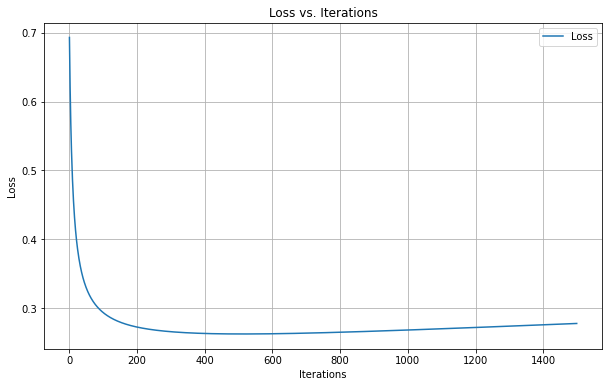

----------------
TRUE: 288 (39.13%)
FALSE: 448 (60.87%)
Fold 2, Score: {'accuracy': 0.9198369565217391, 'precision': 0.8778877887788779, 'recall': 0.9236111111111112}


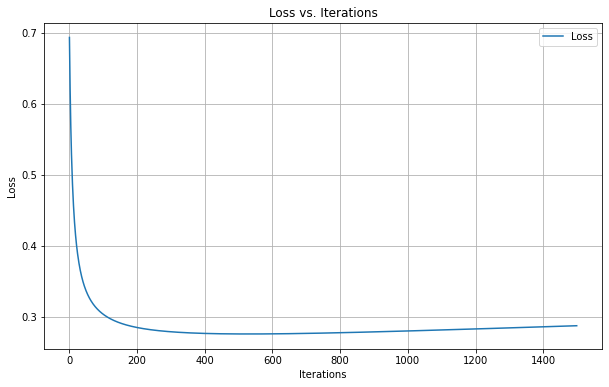

----------------
TRUE: 256 (34.78%)
FALSE: 480 (65.22%)
Fold 3, Score: {'accuracy': 0.936141304347826, 'precision': 0.88, 'recall': 0.9453125}


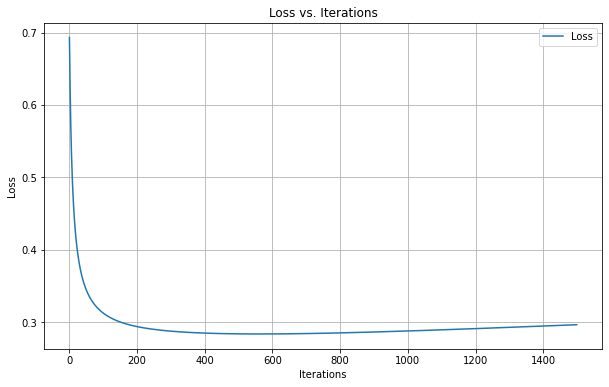

----------------
TRUE: 264 (35.87%)
FALSE: 472 (64.13%)
Fold 4, Score: {'accuracy': 0.9279891304347826, 'precision': 0.8781362007168458, 'recall': 0.928030303030303}


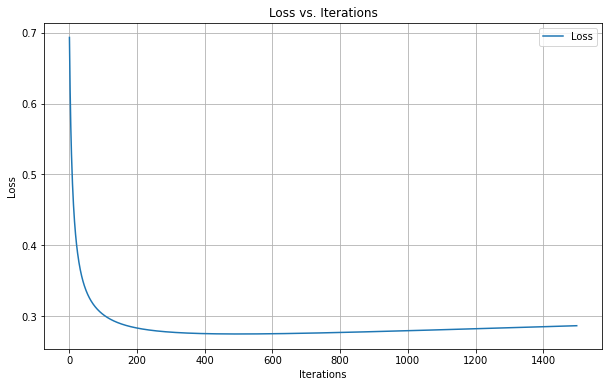

----------------
TRUE: 267 (36.28%)
FALSE: 469 (63.72%)
Fold 5, Score: {'accuracy': 0.9035326086956522, 'precision': 0.8356164383561644, 'recall': 0.9138576779026217}


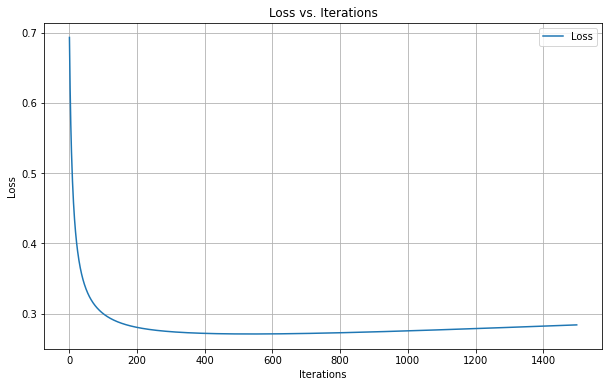

----------------


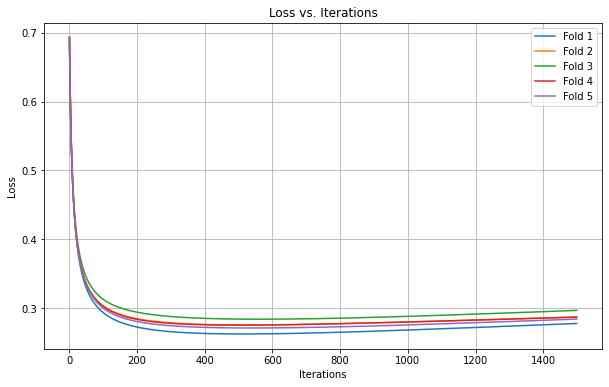

In [36]:
cross_validation(X_train,y_train)